In [8]:
# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# General imports
import os
import torch
import torch.quantization
import pytorch_lightning as pl
from copy import deepcopy
import random
random.seed(42)
import copy
torch.use_deterministic_algorithms(True)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model Specific imports
from vilt.modules import ViLTransformerSS


# Custom imports
import configs
from quantization_utils import get_module_by_path, quantize_modules
from quantization_utils import  SmallMTDataModuleVILT



In [9]:
# Set the configuration
_config = configs.vilt_config_nlvr2
_config["batch_size"] = 8
_config["per_gpu_batchsize"] = 8
_config["learning_rate"] = 2e-4

# Set the PyTorch Lightning seed
pl.seed_everything(_config["seed"])

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use

Seed set to 0


Test Dataloader Length:  2
Length of the first batch: 8
Shape of the first batch: torch.Size([8, 3, 576, 608])


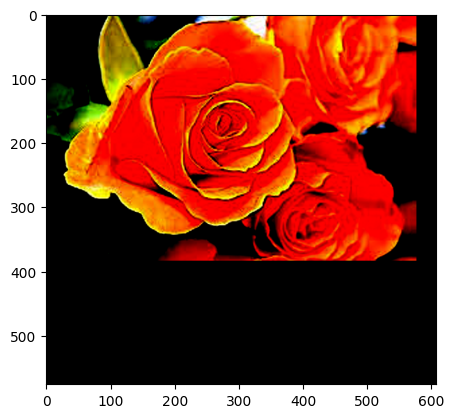

In [10]:
dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=10)
dm.setup("test")
test_dataloader = dm.test_dataloader()

print("Test Dataloader Length: ", len(test_dataloader))

print(f"Length of the first batch: {len(next(iter(test_dataloader))['answers'])}")
print(f"Shape of the first batch: {next(iter(test_dataloader))['image_0'][0].shape}")

# Plot the first image from the first batch of the test and validation dataloaders
import matplotlib.pyplot as plt
plt.imshow(next(iter(test_dataloader))['image_0'][0][0].permute(1, 2, 0))
plt.show()


# Get the batch
for i, batch in enumerate(test_dataloader):
    if i == 0:
        break

# Register hooks

In [11]:
# # Initialize a container to store features for all blocks
# feature_container = {
#     # Format: {block_idx: output_tensor}
#     "student": {},
#     "teacher": {}
# }

# def register_all_hooks(student_model, teacher_model):
#     """Register hooks for all blocks in both models."""
#     def _create_hook(container, model_type, block_idx):
#         # Closure to capture the model_type and block_idx
#         def hook(module, inp, out):
#             container[model_type][block_idx] = out  # Store output tensor
#         return hook

#     teacher_model.pooler.dense.register_forward_hook(_create_hook(feature_container, "student", 0))
#     student_model.pooler.dense.register_forward_hook(_create_hook(feature_container, "teacher", 0))
    
#     # # Register hooks for every student block
#     # for block_idx, block in enumerate(student_model.transformer.blocks):
#     #     hook = _create_hook(feature_container, "student", block_idx)
#     #     # block.mlp.fc2.register_forward_hook(hook)
#     #     block.register_forward_hook(hook)

#     # # Register hooks for every teacher block
#     # for block_idx, block in enumerate(teacher_model.transformer.blocks):
#     #     hook = _create_hook(feature_container, "teacher", block_idx)
#     #     # block.mlp.fc2.register_forward_hook(hook)
#     #     block.register_forward_hook(hook)

In [12]:
# Initialize a container to store features for all blocks
feature_container = {
    # Format: {block_idx: output_tensor}
    "student": {},
    "teacher": {}
}

def register_all_hooks(student_model, teacher_model):
    """Register hooks for all blocks in both models."""
    def _create_hook(container, model_type, block_idx):
        # Closure to capture the model_type and block_idx
        def hook(module, inp, out):
            if block_idx == "transform":
                container[model_type][block_idx] = out[:, 0] #out  # Store output tensor
            else:
                container[model_type][block_idx] = out[0][:, 0] #out  # Store output tensor
        return hook

    # teacher_model.pooler.dense.register_forward_hook(_create_hook(feature_container, "student", 0))
    # student_model.pooler.dense.register_forward_hook(_create_hook(feature_container, "teacher", 0))

    # Register hooks for every student block
    for block_idx, block in enumerate(student_model.transformer.blocks):
        hook = _create_hook(feature_container, "student", block_idx)
        # block.mlp.fc2.register_forward_hook(hook)
        block.register_forward_hook(hook)

    # Register hooks for every teacher block
    for block_idx, block in enumerate(teacher_model.transformer.blocks):
        hook = _create_hook(feature_container, "teacher", block_idx)
        # block.mlp.fc2.register_forward_hook(hook)
        block.register_forward_hook(hook)

In [13]:
# =============== Initialize Full Precision Model ==============
teacher_model = ViLTransformerSS(_config)
teacher_model.eval()

teacher_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)
teacher_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=2)

# student_model = ViLTransformerSS(_config)
# student_model.eval()

{'text_feats': tensor([[[ 0.6123,  0.3103, -0.4980,  ..., -0.2302,  0.4382,  0.1983],
          [-0.2413,  0.0952,  0.1662,  ..., -0.5769,  0.0256,  0.0590],
          [ 0.1393,  0.3437, -0.0195,  ..., -0.3762, -0.0960,  0.0910],
          ...,
          [ 0.1078,  0.2290, -0.2657,  ..., -0.3186,  0.2228,  0.0247],
          [-0.1552,  0.2319, -0.0225,  ..., -0.4275,  0.2128, -0.0551],
          [ 0.0916,  0.0569, -0.0867,  ..., -0.1995,  0.3168,  0.0862]],
 
         [[ 0.2875, -0.2108, -0.0787,  ...,  0.2822,  0.2951,  0.2769],
          [ 0.3325,  0.1246,  0.1172,  ..., -0.1490, -0.1959, -0.1138],
          [ 0.3583,  0.2389, -0.0869,  ...,  0.1534,  0.3805,  0.1255],
          ...,
          [ 0.1461, -0.0624,  0.0044,  ...,  0.2222,  0.1800,  0.0327],
          [ 0.1518, -0.0672, -0.0025,  ...,  0.2029,  0.2090, -0.1200],
          [ 0.0542, -0.1029,  0.0582,  ...,  0.0658,  0.1311,  0.0182]],
 
         [[ 0.4727,  0.2412, -0.0680,  ...,  0.0221,  0.4153, -0.1050],
          [ 0.

# Quantize the student

In [15]:
import torch.nn.functional as F

for i in range(12):
    student_model = deepcopy(teacher_model)

    modules_to_train = {'layer_names': [f"transformer.blocks.{i}.mlp.fc1",
                                        f"transformer.blocks.{i}.mlp.fc2",]
                        }

    # Quantize the model
    quantize_modules(student_model, modules_to_train['layer_names'], 4)

    register_all_hooks(student_model, teacher_model)

    student_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)
    teacher_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)

    cos_sim = F.cosine_similarity(feature_container["student"][i], feature_container["teacher"][i], dim=-1)
    mse_los = F.mse_loss(feature_container["student"][i], feature_container["teacher"][i])
    print(f"Layer {i}: Cosine Similarity \t: {cos_sim.mean()}")
    print(f"Layer {i}: MSE LOSS \t \t: {mse_los.mean()}")
    


    # # Calculate the MSE between student and teacher features
    # mse_container = {}
    # for block_idx in feature_container["student"]:
    #     mse_container[block_idx] = torch.nn.functional.mse_loss(feature_container["student"][block_idx], feature_container["teacher"][block_idx])

    # # Print the MSE values
    # for block_idx, mse in mse_container.items():
    #     # print(f"Block: {block_idx} | MSE: {mse.item()}")
    #     print(f"Block {i} | MSE: {mse.item()}")

Layer 0: Cosine Similarity 	: 0.967810869216919
Layer 0: MSE LOSS 	 	: 0.16368405520915985
Layer 1: Cosine Similarity 	: 0.9812853932380676
Layer 1: MSE LOSS 	 	: 0.12970392405986786
Layer 2: Cosine Similarity 	: 0.9872168898582458
Layer 2: MSE LOSS 	 	: 0.13168084621429443
Layer 3: Cosine Similarity 	: 0.9890307188034058
Layer 3: MSE LOSS 	 	: 0.1328255981206894
Layer 4: Cosine Similarity 	: 0.9828683137893677
Layer 4: MSE LOSS 	 	: 0.2698131203651428
Layer 5: Cosine Similarity 	: 0.991252601146698
Layer 5: MSE LOSS 	 	: 0.1646978110074997
Layer 6: Cosine Similarity 	: 0.9833977222442627
Layer 6: MSE LOSS 	 	: 0.37385234236717224
Layer 7: Cosine Similarity 	: 0.9839991331100464
Layer 7: MSE LOSS 	 	: 0.5016838908195496
Layer 8: Cosine Similarity 	: 0.9828209280967712
Layer 8: MSE LOSS 	 	: 0.6937947869300842
Layer 9: Cosine Similarity 	: 0.9869880080223083
Layer 9: MSE LOSS 	 	: 0.8343660235404968
Layer 10: Cosine Similarity 	: 0.9926000833511353
Layer 10: MSE LOSS 	 	: 0.650764882564

KeyboardInterrupt: 

4bit quant accrucay of self-attention layers represents the MSE of pooler layer:

Block 0 | MSE: 0.4309034049510956

Block 1 | MSE: 0.11729031801223755

Block 2 | MSE: 0.05843155086040497

Block 3 | MSE: 0.014226551167666912

Block 4 | MSE: 0.02007165551185608

Block 5 | MSE: 0.01236399170011282

Block 6 | MSE: 0.10226938128471375

Block 7 | MSE: 0.06629931926727295

Block 8 | MSE: 0.095265232026577

Block 9 | MSE: 0.08393976837396622

Block 10 | MSE: 0.05277823284268379

Block 11 | MSE: 0.025818971917033195

In [29]:
# import matplotlib.pyplot as plt

# # Plot the first instance of the fusion layer output for each head
# for i in range(12):
#     # for j in range(8):
#     block = i
#     # head = j

#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#     fig.suptitle(f'Block: {block}', fontsize=16)
    
#     # Plot student features
#     im1 = axes[0].imshow(feature_container["student"][block].detach().cpu().numpy())
#     axes[0].set_title('Student')
#     fig.colorbar(im1, ax=axes[0])
    
#     # Plot teacher features
#     im2 = axes[1].imshow(feature_container["teacher"][block].detach().cpu().numpy())
#     axes[1].set_title('Teacher')
#     fig.colorbar(im2, ax=axes[1])
    
#     plt.tight_layout()
#     plt.show()